In [1]:
import rasterio
import torch
from terratorch.registry import BACKBONE_REGISTRY
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
file_path = '/mnt/ADV_VISION/Dataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_7496_LabelHand.tif'  # Replace with your actual file path

with rasterio.open(file_path) as src:
    print("Number of bands:", src.count)
    print("Height (pixels):", src.height)
    print("Width (pixels):", src.width)
    print("Shape (bands, height, width):", (src.count, src.height, src.width))


/mnt/venv888/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of bands: 1
Height (pixels): 512
Width (pixels): 512
Shape (bands, height, width): (1, 512, 512)


In [2]:
import os

label_dir = '/mnt/ADV_VISION/Dataset/v1.1/data/flood_events/HandLabeled/LabelHand/'
label_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.tif')]
print("Number of label files:", len(label_files))
print("Example file:", label_files[0])


Number of label files: 446
Example file: /mnt/ADV_VISION/Dataset/v1.1/data/flood_events/HandLabeled/LabelHand/India_1050276_LabelHand.tif


Label shape: (512, 512)
Unique values in mask: {np.int16(0), np.int16(1), np.int16(-1)}


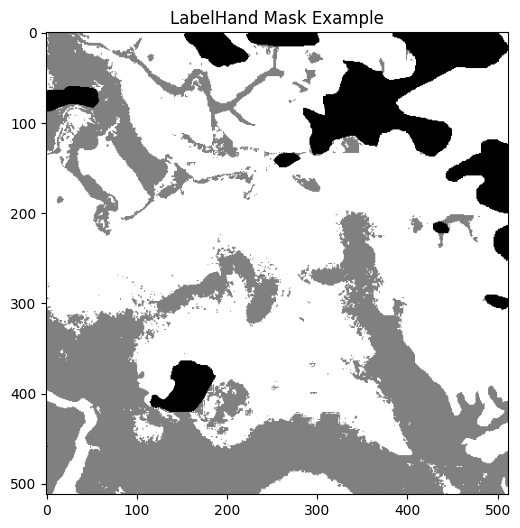

In [3]:
import rasterio
import matplotlib.pyplot as plt

# Read the first label file
with rasterio.open(label_files[1]) as src:
    label = src.read(1)  # Read first (and only) band
    print("Label shape:", label.shape)
    print("Unique values in mask:", set(label.flatten()))

# Display the label image
plt.figure(figsize=(6,6))
plt.imshow(label, cmap='gray')
plt.title('LabelHand Mask Example')
# plt.colorbar(label='Class')
plt.show()


In [4]:
import csv
import os
def read_prithvi_bands_from_dir(dir_path,mask_dir_path ,csv_path):
    images = []
    masks = []

    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) >= 2:
                input_rel, mask_rel = row[0], row[1]
                input_rel = input_rel.replace("S1Hand", "S2Hand")


                input_full = os.path.join(dir_path, input_rel)
                mask_full = os.path.join(mask_dir_path, mask_rel)
                with rasterio.open(input_full) as src:
                    img = src.read([2, 3, 4, 9, 11, 12])  # 1-based band indices
                    img = img / 10000.0  # Normalize reflectance if needed
                    images.append(img)
                with rasterio.open(mask_full) as src:
                    mask = src.read(1)
                    mask = (mask).astype(np.int64)  
                    masks.append(mask)

    if images:
        print('Number of images read:', len(images))
        print('Shape of first image:', images[0].shape)  # (6, height, width)
    else:
        print('No images found in directory')
    if masks:
        print('Number of masks read:', len(masks))
        print('Shape of first mask:', masks[0].shape)  # (height, width)
        print('Unique values in first mask:', np.unique(masks[0]))  # Should show 0, 1, and possibly -1
    else:
        print('No masks found in directory')
    return images, masks

In [5]:
img_path='/mnt/ADV_VISION/Dataset/v1.1/data/flood_events/HandLabeled/S2Hand'
masks_path='/mnt/ADV_VISION/Dataset/v1.1/data/flood_events/HandLabeled/LabelHand'
train_img, train_mask = read_prithvi_bands_from_dir(img_path, masks_path,'/mnt/ADV_VISION/v1.1C/splits/flood_handlabeled/flood_train_data.csv')
val_img, val_mask = read_prithvi_bands_from_dir(img_path, masks_path,'/mnt/ADV_VISION/v1.1C/splits/flood_handlabeled/flood_valid_data.csv')
test_img, test_mask = read_prithvi_bands_from_dir(img_path, masks_path,'/mnt/ADV_VISION/v1.1C/splits/flood_handlabeled/flood_test_data.csv')

Number of images read: 252
Shape of first image: (6, 512, 512)
Number of masks read: 252
Shape of first mask: (512, 512)
Unique values in first mask: [-1  0  1]
Number of images read: 89
Shape of first image: (6, 512, 512)
Number of masks read: 89
Shape of first mask: (512, 512)
Unique values in first mask: [-1]
Number of images read: 90
Shape of first image: (6, 512, 512)
Number of masks read: 90
Shape of first mask: (512, 512)
Unique values in first mask: [-1  0  1]


In [6]:
##Task specific small model
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleFloodCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                            

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                             

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                            
        )

        # Decoder: Upsample to original resolution
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  

            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  

            nn.Conv2d(32, 3, kernel_size=1)  
        )

    def forward(self, x):
        features = self.encoder(x)
        logits = self.decoder(features)
        return logits 
import torch
from torch import nn


def test_model():
    model = SimpleFloodCNN()
    dummy_input = torch.randn(1, 6, 512, 512)  
    output = model(dummy_input)
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")  

if __name__ == '__main__':
    test_model()


Input shape: torch.Size([1, 6, 512, 512])
Output shape: torch.Size([1, 3, 512, 512])


In [7]:
import matplotlib.pyplot as plt

def plot_sensitivity(miou_histories, labels):

    for miou, label in zip(miou_histories, labels):
        plt.plot(miou, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Validation mIoU')
    plt.title('Sensitivity Analysis: mIoU vs Training Data Amount')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def compute_iou(output, target):
    output = output.flatten()
    target = target.flatten()
    
    mask = (target == 1) | (target == 2)
    
    output_filtered = output[mask]
    target_filtered = target[mask]
    
    intersection = torch.sum(output_filtered == target_filtered)
    union = output_filtered.numel()  
    
    return (intersection + 1e-7) / (union + 1e-7)
def train_model(
    train_imgs, train_masks, 
    val_imgs, val_masks, 
    test_imgs, test_masks,  # NEW: test data
    model_class, 
    num_classes=3, 
    epochs=100, 
    lr=1e-3, 
    loss_fn=None, 
    optimizer_class=None,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class().to(device)
    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
    if optimizer_class is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr)
    
    miou_history = []
    best_miou = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for img, mask in zip(train_imgs, train_masks):
            inputs = torch.tensor(img, device=device).float().unsqueeze(0)
            targets = torch.tensor(mask+1, device=device).long().unsqueeze(0)

            optimizer.zero_grad()
            logits = model(inputs)
            preds = torch.argmax(logits, dim=1)

            loss = loss_fn(logits, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        with torch.no_grad():
            for img, mask in zip(val_imgs, val_masks):
                inputs = torch.tensor(img, device=device).float().unsqueeze(0)
                targets = torch.tensor(mask+1, device=device).long().unsqueeze(0)
                logits = model(inputs)
                loss = loss_fn(logits, targets)
                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                val_miou += compute_iou(preds.cpu(), targets.cpu())

        val_miou /= len(val_imgs)
        miou_history.append(val_miou)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_imgs):.4f} | "
              f"Val Loss: {val_loss/len(val_imgs):.4f} | Val mIoU: {val_miou:.4f}")
        
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), "best_model.pth")
            print(f"  Saved new best model with mIoU {best_miou:.4f}")

    test_miou = 0.0
    with torch.no_grad():
        for img, mask in zip(test_imgs, test_masks):
            inputs = torch.tensor(img, device=device).float().unsqueeze(0)
            targets = torch.tensor(mask+1, device=device).long().unsqueeze(0)
            logits = model(inputs)
            preds = torch.argmax(logits, dim=1)
            test_miou += compute_iou(preds.cpu(), targets.cpu())

    test_miou /= len(test_imgs)
    print(f"\n✅ Final Test mIoU: {test_miou:.4f}")
    # model.eval()
    # with torch.no_grad():
    #     sample_img = torch.tensor(test_imgs[0], device=device).float().unsqueeze(0)
    #     sample_mask = test_masks[0]
    #     logits = model(sample_img)
    #     pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy() - 1  # Shift back to original labels


    return model, miou_history, test_miou



🔍 Training with 100% of data (252 samples)...
Epoch 1/100 | Train Loss: 0.6022 | Val Loss: 0.6305 | Val mIoU: 0.9221
  Saved new best model with mIoU 0.9221
Epoch 2/100 | Train Loss: 0.6049 | Val Loss: 0.6303 | Val mIoU: 0.9118
Epoch 3/100 | Train Loss: 0.5879 | Val Loss: 0.6328 | Val mIoU: 0.9010
Epoch 4/100 | Train Loss: 0.5500 | Val Loss: 0.5191 | Val mIoU: 0.8896
Epoch 5/100 | Train Loss: 0.5229 | Val Loss: 0.5264 | Val mIoU: 0.8876
Epoch 6/100 | Train Loss: 0.4904 | Val Loss: 0.5073 | Val mIoU: 0.8891
Epoch 7/100 | Train Loss: 0.4678 | Val Loss: 0.4526 | Val mIoU: 0.9333
  Saved new best model with mIoU 0.9333
Epoch 8/100 | Train Loss: 0.4433 | Val Loss: 0.3956 | Val mIoU: 0.9447
  Saved new best model with mIoU 0.9447
Epoch 9/100 | Train Loss: 0.4109 | Val Loss: 0.4046 | Val mIoU: 0.9515
  Saved new best model with mIoU 0.9515
Epoch 10/100 | Train Loss: 0.4153 | Val Loss: 0.6928 | Val mIoU: 0.9506
Epoch 11/100 | Train Loss: 0.4079 | Val Loss: 0.4760 | Val mIoU: 0.9446
Epoch 12/1

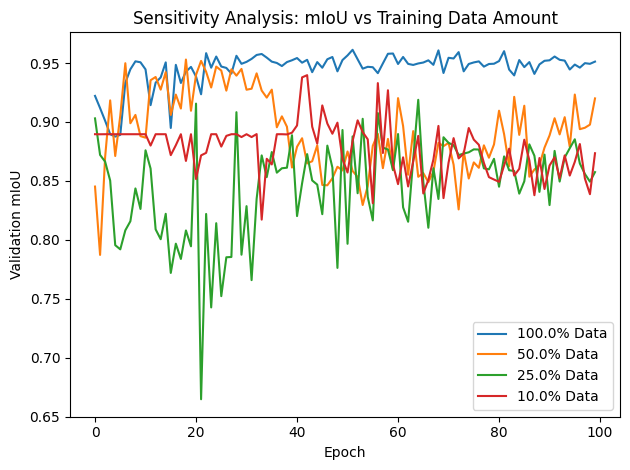


📊 Final Test mIoU Summary:
╒══════════════════════╤═════════════╕
│ Training Data Used   │   Test mIoU │
╞══════════════════════╪═════════════╡
│ 100.0% Data          │      0.9304 │
├──────────────────────┼─────────────┤
│ 50.0% Data           │      0.8965 │
├──────────────────────┼─────────────┤
│ 25.0% Data           │      0.8845 │
├──────────────────────┼─────────────┤
│ 10.0% Data           │      0.8482 │
╘══════════════════════╧═════════════╛


In [9]:
from tabulate import tabulate

def run_sensitivity_analysis(full_train_data, full_train_masks, val_data, val_masks, test_data, test_masks):
    data_fractions = [1.0,0.5, 0.25, 0.1]
    histories = []
    test_mious = []

    for frac in data_fractions:
        n_samples = int(len(full_train_data) * frac)
        train_subset = full_train_data[:n_samples]
        mask_subset = full_train_masks[:n_samples]
        
        print(f"\n🔍 Training with {frac*100:.0f}% of data ({n_samples} samples)...")
        
        model, history, test_miou = train_model(
            train_subset, mask_subset,
            val_data, val_masks,
            test_data, test_masks,
            model_class=SimpleFloodCNN
        )
        
        histories.append((f"{frac*100}% Data", history))
        test_mious.append(test_miou)
    
    plot_sensitivity([h[1] for h in histories], [h[0] for h in histories])

    table = [(label, f"{miou:.4f}") for label, miou in zip([h[0] for h in histories], test_mious)]
    print("\n📊 Final Test mIoU Summary:")
    print(tabulate(table, headers=["Training Data Used", "Test mIoU"], tablefmt="fancy_grid"))
run_sensitivity_analysis(train_img, train_mask, val_img, val_mask,test_img, test_mask)
